# Clustering samples by environmental and functional data

The aim here is to cluster samples both by their measured environmental data and the functional metaomics data in order to identify sample groups to be used for statistical analyses.

In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, os
from sklearn import cluster, manifold
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage,dendrogram,leaves_list,fcluster

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
plt.style.use('ggplot')

## Functionality

In [2]:
#def standardize(df):
#    ts_stand = (df - df.mean()) / df.std()
#    return ts_stand
def standardize(df):
    df = df.T
    for i in df.index:
        df.loc[i,:] = (df.loc[i,:]-df.loc[i].min()) / df.loc[i].max()
    return df.T

In [3]:
def paired_dendrograms(meta,fun,combined=pd.DataFrame(),metric="correlation",method="complete",wspace=0.75,x=8,y=4,color_threshold=None, t=1):
    if color_threshold:
        if type(color_threshold)==int or type(color_threshold)==float: color_threshold = [color_threshold]*3
    else:
        color_threshold = [None,None,None]
    if combined.empty: fig,axes = plt.subplots(ncols=2,nrows=1)
    else: fig,axes = plt.subplots(ncols=3,nrows=1,figsize=(x,y))
    
    meta_dist = pdist(meta,metric=metric)
    meta_Z = linkage(meta_dist,method=method,metric=metric)
    
    fun_dist = pdist(fun,metric=metric)
    fun_Z = linkage(fun_dist,method=method,metric=metric)
    fun_g = pd.DataFrame(fcluster(fun_Z,criterion="distance",t=t),index=fun.index).to_dict()[0]
    fun_labels = [x+" ("+str(fun_g[x])+")" for x in fun.index]
    
    if not combined.empty: com_dist = pdist(combined,metric=metric)
    
    dendrogram(meta_Z,labels=meta.index,ax=axes[0],orientation="left", color_threshold=color_threshold[0]);
    axes[0].set_title("Metadata")
    
    dendrogram(linkage(fun_dist,method=method,metric=metric),labels=fun_labels,ax=axes[1],orientation="right", color_threshold=color_threshold[1]);
    axes[1].set_title("Functional")
    if not combined.empty: 
        dendrogram(linkage(com_dist,method=method,metric=metric),labels=combined.index,ax=axes[2],orientation="right", color_threshold=color_threshold[2]);
        axes[2].set_title("Combined")
    fig.subplots_adjust(wspace=wspace)

In [4]:
def dist_dataframe(df,metric="correlation"):
    dist = pdist(df,metric=metric)
    return pd.DataFrame(squareform(dist),columns=df.index, index=df.index)

In [5]:
def plot_env_groupings(f,e,metric,method,threshold,order=False):
    d = pdist(f,metric=metric)
    Z = linkage(d,method=method)
    g = pd.DataFrame(fcluster(Z,criterion="distance",t=threshold),index=f.index).to_dict()[0]
    e["Sample"] = e.index
    e["Group"] = [g[x] for x in e.index]
    em = pd.melt(e,id_vars=["Sample","Group"])
    if order: x_order = order
    else: x_order = sorted(set(g.values()))
    ax = sns.factorplot(data=em, col="variable", col_wrap=3, x="Group", order=x_order, 
                    y="value",errwidth=0.5,sharey=False,sharex=False,scale=0.5, size=2, aspect=1.5)
    ax.set_titles("{col_name}");
    for a in ax.axes: a.set_xticklabels(a.get_xticklabels(), rotation=90,fontsize=8);
    ax.fig.subplots_adjust(wspace=.15, hspace=1)
    return g

In [6]:
def get_cumulative_proportion(df, c=0.75):
    df_season_sum = df.groupby(level=0).sum().sum(axis=1).sort_values(ascending=False)
    tmp = df_season_sum.div(df_season_sum.sum())
    cumulative_sum = []
    for i,t in enumerate(tmp.index):
        cumulative_sum.append(tmp[0:i+1].sum())
    tmp = pd.DataFrame(tmp)
    tmp = tmp.assign(SUM=pd.Series(cumulative_sum, index=tmp.index))
    df = df.loc[tmp.loc[tmp.SUM<=c].index]
    return df

## Load the data

### Load the environmental data.

In [7]:
metadata = pd.read_csv("data/LMO.time.series.metadata.csv", header=0, sep="\t", index_col=0)
metadata.rename(index=lambda x: str(x)[2:], inplace=True)
metavars = ["Temperature","Chla","Phosphate","Nitrate","Silicate","Ammonium"]

### Load the metaomic data

This data has been processed using the [process_data](process_data.ipynb) notebook.

In [8]:
mg_trans = pd.read_table("results/mg/all_trans.tpm.tsv", header=0, sep="\t", index_col=0)
mg_trans = mg_trans.loc[mg_trans.sum(axis=1)>0]
mg_trans = get_cumulative_proportion(mg_trans,c=0.9)

In [9]:
mt_trans = pd.read_table("results/mt/all_trans.tpm.tsv", header=0, sep="\t", index_col=0)
mt_trans = mt_trans.loc[mt_trans.sum(axis=1)>0]
mt_trans = get_cumulative_proportion(mt_trans,c=0.9)

## Make data conform

Make metadata and functional data dataframes match up in term of samples.

In [10]:
mg_metadata = metadata.loc[mg_trans.columns,metavars]
mg_transm = mg_trans[mg_metadata.index].T

The metatranscriptomic time-series are missing values for TotalN for 5 samples and 2 of these samples have no metadata measured.

In [11]:
mt_metadata = metadata.loc[mt_trans.columns, metavars]
mt_metadata.drop(["140916","141013"],inplace=True)
mt_transm = mt_trans.T.loc[set(mt_metadata.index).intersection(mt_trans.columns)]

## Standardize data

Standardize the data to zero mean and standard deviation of 1.

In [12]:
mg_metadata_stand = standardize(mg_metadata)
mg_transm_stand = standardize(mg_transm)

In [13]:
mt_metadata_stand = standardize(mt_metadata)
mt_transm_stand = standardize(mt_transm)

Combine the standardized dataframes per dataset.

In [14]:
mg_combined = pd.concat([mg_transm_stand,mg_metadata_stand],axis=1)

In [15]:
mt_combined = pd.concat([mt_transm_stand,mt_metadata_stand],axis=1)

## Dendrograms

### Metagenomes

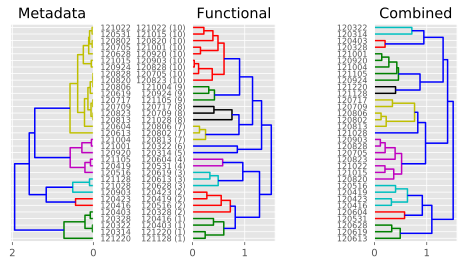

In [16]:
paired_dendrograms(mg_metadata_stand, mg_transm_stand, mg_combined, method="complete", metric="correlation", wspace=1.2,t=0.8,color_threshold=0.8)
#plt.savefig("results/figures/mg_sample_clusters.png", bbox_inches="tight", dpi=300)

- early-spring: 120314, 120322
- spring: **(121128, 121220)**, 130328, 120516, 120419, 120423
- early-summer: 120628, 120613, 120619, 120531, 120604
- summer:  120813, 120802, 120806, **121028**, 120709, 120717
- fall/winter: 120823, 120705, 120828, 120903, 120920, 121001, **120820**, 121015, 121022

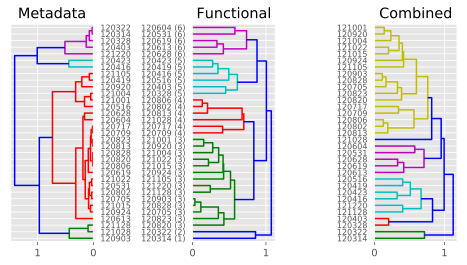

In [17]:
paired_dendrograms(mg_metadata_stand, mg_transm_stand, mg_combined, method="average", metric="correlation", wspace=1.2,t=0.8,color_threshold=0.8)

- early-spring: 120314, 120322
- spring: 120328, 120403, 120516, 120416, 120419, 120423
- early-summer: 120628, 120613, 120619, 120531, 120604
- summer: 120709, 120717, **121028**, 120813, 120802, 120806
- fall: 120820, 120823, 120705, 120828, 120903
- winter: 121128, 121220, 121105, 120924, 121015, 121022, 121004, 120920, 121001

Based on the hierarchical clustering results the following groups were defined:

- early-spring (120314, 120322)
- spring (120328, 120403, 120416, 120419, 120423, 120516)
- early-summer (120531, 120604, 120613, 120619, 120628)
- summer (120709, 120717, 120802, 120806, 120813)
- fall (*120705*, 120820, 120823, 120828, 120903)
- winter (120920, 120924, 121001, 121004, 121015, 121022, 121105, 121128, 121220)

In [18]:
mg_groupdict = {"early-spring": ["120314","120322"],
                "spring": ["120328","120403","120416","120423","120419","120516"],
                "early-summer":["120531","120604","120613","120619","120628"],
                "summer": ["120709","120717","120802","120806","120813"],
                "fall": ["120705","120820","120823","120828","120903"],
                "winter": ["120920","120924","121001","121004","121015","121022","121105","121128","121220"]}


In [19]:
mg_man = {}
for group, samplelist in mg_groupdict.items():
    for sample in samplelist:
        mg_man[sample] = group

Plot the environmental data for the defined sample groups.

In [20]:
mg_group_env = mg_metadata.loc[mg_man.keys()]
mg_group_env["Sample"] = mg_group_env.index
mg_group_env["Group"] = [mg_man[x] for x in mg_group_env["Sample"]]

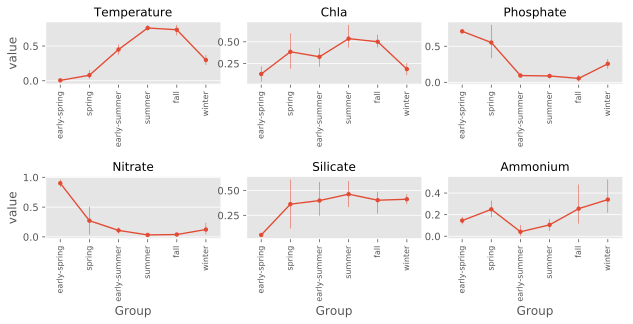

In [21]:
mg_group_env = mg_metadata.loc[mg_man.keys()]
mg_group_env["Sample"] = mg_group_env.index
mg_group_env["Group"] = [mg_man[x] for x in mg_group_env["Sample"]]
mg_group_env = pd.melt(mg_group_env,id_vars=["Sample","Group"])
ax = sns.factorplot(data=mg_group_env, col="variable", col_wrap=3, x="Group", 
                    order=["early-spring","spring","early-summer","summer","fall","winter"],
                    y="value",errwidth=0.5,sharey=False,sharex=False,scale=0.5, size=2, aspect=1.5)
ax.set_titles("{col_name}");
for a in ax.axes: a.set_xticklabels(a.get_xticklabels(), rotation=90,fontsize=8);
ax.fig.subplots_adjust(wspace=.15, hspace=1.5)
plt.savefig("results/figures/mg_sample_clusters_metadata.png", bbox_inches="tight", dpi=300)

Re-plot dendrogram with groupings.

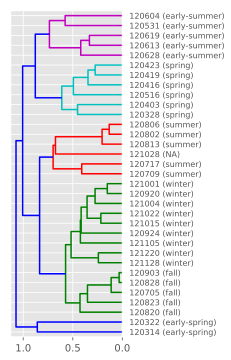

In [22]:
mg_map = {}
for i in mg_transm.index:
    try: mg_map[i] = mg_man[i]
    except KeyError: mg_map[i] = "NA"
mg_grouped_stand = mg_transm.copy()
mg_grouped_stand = mg_grouped_stand.rename(index=lambda x: "{} ({})".format(x,mg_map[x]))
d = pdist(mg_grouped_stand,metric="correlation")
Z = linkage(d,method="average")
plt.figure(figsize=(2,6))
ax = dendrogram(Z,orientation="left",labels=mg_grouped_stand.index, color_threshold=0.8)
#plt.savefig("results/figures/mg_sample_clusters_groups.png",dpi=300, bbox_inches="tight")

Write sample groups to file.

In [23]:
(pd.DataFrame(mg_man,index=["Group"]).T).to_csv("results/mg/samplegroups.tab", sep="\t")

### Metatranscriptomes

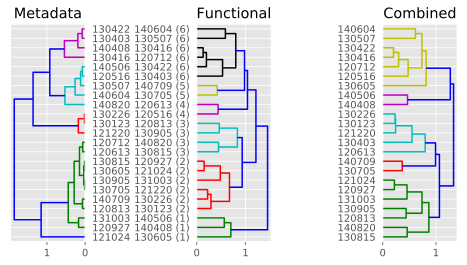

In [24]:
paired_dendrograms(mt_metadata_stand, mt_transm_stand, mt_combined, method="complete", metric="correlation", wspace=1.5,t=0.9, color_threshold=0.9)
#plt.savefig("results/figures/mt_sample_clusters.png", bbox_inches="tight", dpi=300)

- spring: 130403, 130422, 130416, **120712**, 130507, 140604
- early-summer: 130605, 140408, 140506
- summer: 130815, 140820, 120813, 130905
- winter: 130226, 130123, 121220, 131003, 120927, 121024

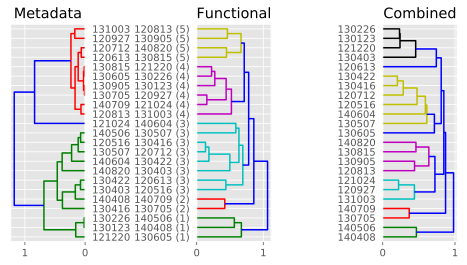

In [25]:
paired_dendrograms(mt_metadata_stand, mt_transm_stand, mt_combined, method="average", metric="correlation", wspace=1.5,t=0.7, color_threshold=0.7)
#plt.savefig("results/figures/mt_sample_clusters.png", bbox_inches="tight", dpi=300)

- spring: 130403, 130422, 130416, **120712**, 130507, 140604
- early-summer: 130605, 140408, 140506
- summer: 130815, 140820, 120813, 130905
- winter: 131003, 120927, 121024, 130123, 130226, 121220

In [26]:
mt_groupdict = {"spring": ["130403","130422","130416","120712","130507","140604"],
                "early-summer":["130605","140408","140506"],
                "summer": ["130815","140820","120813","130905"],
                "winter": ["131003","120927","130123","130226","121220"]}

In [27]:
mt_man = {}
for group, samplelist in mt_groupdict.items():
    for sample in samplelist:
        mt_man[sample] = group

In [28]:
mt_group_env = mt_metadata.loc[mt_man.keys()]
mt_group_env["Sample"] = mt_group_env.index
mt_group_env["Group"] = [mt_man[x] for x in mt_group_env["Sample"]]

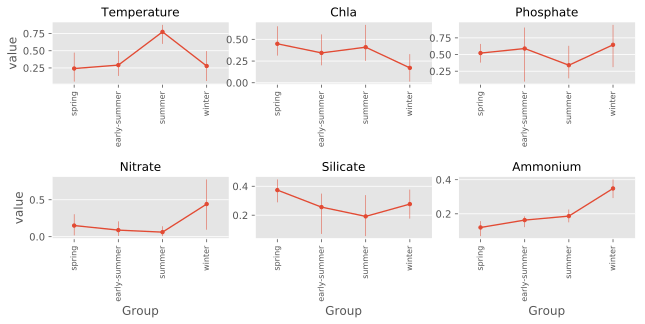

In [29]:
mt_group_env = mt_metadata.loc[mt_man.keys()]
mt_group_env["Sample"] = mt_group_env.index
mt_group_env["Group"] = [mt_man[x] for x in mt_group_env["Sample"]]
mt_group_env = pd.melt(mt_group_env,id_vars=["Sample","Group"])
ax = sns.factorplot(data=mt_group_env, col="variable", col_wrap=3, x="Group", 
                    order=["spring","early-summer","summer","winter"],
                    y="value",errwidth=0.5,sharey=False,sharex=False,scale=0.5, size=2, aspect=1.5)
ax.set_titles("{col_name}");
for a in ax.axes: a.set_xticklabels(a.get_xticklabels(), rotation=90,fontsize=8);
ax.fig.subplots_adjust(wspace=.15, hspace=1.5)
plt.savefig("results/figures/mt_sample_clusters_metadata.png", bbox_inches="tight", dpi=300)

Create labelled dendrogram for transporters.

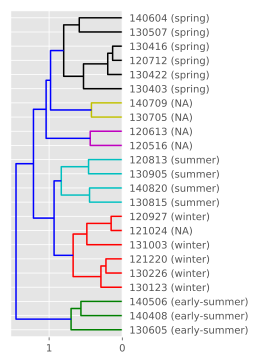

In [30]:
mt_map = {}
for i in mt_transm.index:
    try: mt_map[i] = mt_man[i]
    except KeyError: mt_map[i] = "NA"
        
mt_grouped_stand = mt_transm.rename(index=lambda x: "{} ({})".format(x,mt_map[x]))
d = pdist(mt_grouped_stand,metric="correlation")
Z = linkage(d,method="complete")
plt.figure(figsize=(2,6))
ax = dendrogram(Z,orientation="left",labels=mt_grouped_stand.index, color_threshold=0.9)
plt.savefig("results/figures/mt_sample_clusters_groups.png",dpi=300, bbox_inches="tight")

In [31]:
(pd.DataFrame(mt_man,index=["Group"]).T).to_csv("results/mt/samplegroups.tab",sep="\t")